## This notebook will use Long Short Term Memory (LSTM) to predict RUL for jet engines

In [82]:
# import the libraries
import os
import pandas as pd
import numpy as np
# import scikit-learn use pip install scikit-learn and then use the code right below this
from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline
import matplotlib.pyplot as plt
import glob
import urllib
# Please note that the 'azureml' package requires an active Azure subscription 
# and Azure Machine Learning workspace for certain functionalities. 
# If you're not using Azure Machine Learning, you may need to consider whether 
# you actually need the 'azureml' package or if there's an alternative solution that suits your requirements.
# import azureml
# from azureml.logging import get_azureml_logger
# run_logger = get_azureml_logger()
# run_logger.log('amlrealworld.predictivemaintenanceforpm.dataingestionpreparation','true')

#### Import Train, Test datasets

In [99]:
# read training data 
train_raw_df = pd.read_csv('./data/train_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
train_raw_df = train_raw_df.drop(columns=[26, 27])

# name the cols
train_raw_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_raw_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [100]:
# read test data
test_df = pd.read_csv('./data/test_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
test_df = test_df.drop(columns=[26, 27])

# name the cols
test_df.columns = train_raw_df.columns


test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [101]:
# read ground truth data
truth_df = pd.read_csv('./data/RUL_FD001.txt', sep=" ", header=None)
# remove two columns that have NaN
# Drop column 1 which is NaN
truth_df = truth_df.drop(columns=[1])

truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


#### Training Data: Calculate the RUL for each record
##### The maximum cycle for each unit is the failure cycle.   Thus, we can use this to create the RUL of all the other cycles.

In [102]:
# create df with the unit id and the max cycle
rul = pd.DataFrame(train_raw_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul


,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [103]:
# join the two datasets on the unit id
train_df = train_raw_df.merge(rul, on=['id'], how='left')

# subtract cycle from the max cycles to get RUL
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df = train_df.drop(columns=[('max')])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


##### Create categorical labels
##### label1 = If RUL <=30 then flag as a "1", failure within 30 cycles
##### label2 = multiclass: If RUL <=15 then flag as a "2", failure 16 to 30 = 1, otherwise, 0

In [104]:
w1 = 30
train_df['label1'] = np.where(train_df['RUL'] <= 30, 1, 0 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [105]:
# label2 is multiclass, value 1 is identical to label1,
# value 2 indicates failure within 15 cycles
w0 = 15
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head(180)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,176,-0.0020,-0.0003,100.0,518.67,642.86,1592.27,1422.73,14.62,...,8.4853,0.03,394,2388,100.0,38.72,23.2491,16,1,1
176,1,177,-0.0038,-0.0003,100.0,518.67,643.79,1602.02,1423.99,14.62,...,8.4779,0.03,396,2388,100.0,38.63,23.1673,15,1,2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,2
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,2


##### Training Data: Normalize
We want to preserve original data: id, cycle, RUL, label1, labeel2 for interpretation, and normalize everything else. 
We also need to create a new cycle column that is normalized

In [108]:
# create new cycle col
train_df['cycle_norm'] = train_df['cycle']

# get list of cols that we want to normalize
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
# cols_normalize


In [109]:

# create minmax scaler object
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)


#join the normalized data back to orig dataset, just getting the different cols
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


#### Test Data: Normalized

In [110]:
# create new cycle col
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


##### Test Data: Calculate RUL

In [111]:
# generate column max from the test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

# rename truth_df col from '0' to 'more'
truth_df.columns = ['more']

# # add 1 to zero based index to be equivalent to the unit id in the test dataset
truth_df['id'] = truth_df.index + 1


truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)



In [95]:
truth_df.head()

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [112]:


# # generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
# test_df.drop('max', axis=1, inplace=True)
test_df = test_df.drop(columns=[('max')])
test_df.head()



,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


##### Test Data: Create categorical labels

In [113]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


#### Data Viz

##### Change so showing 10 units with verticle lines at 30 and 15 cycles, and, use training data not test

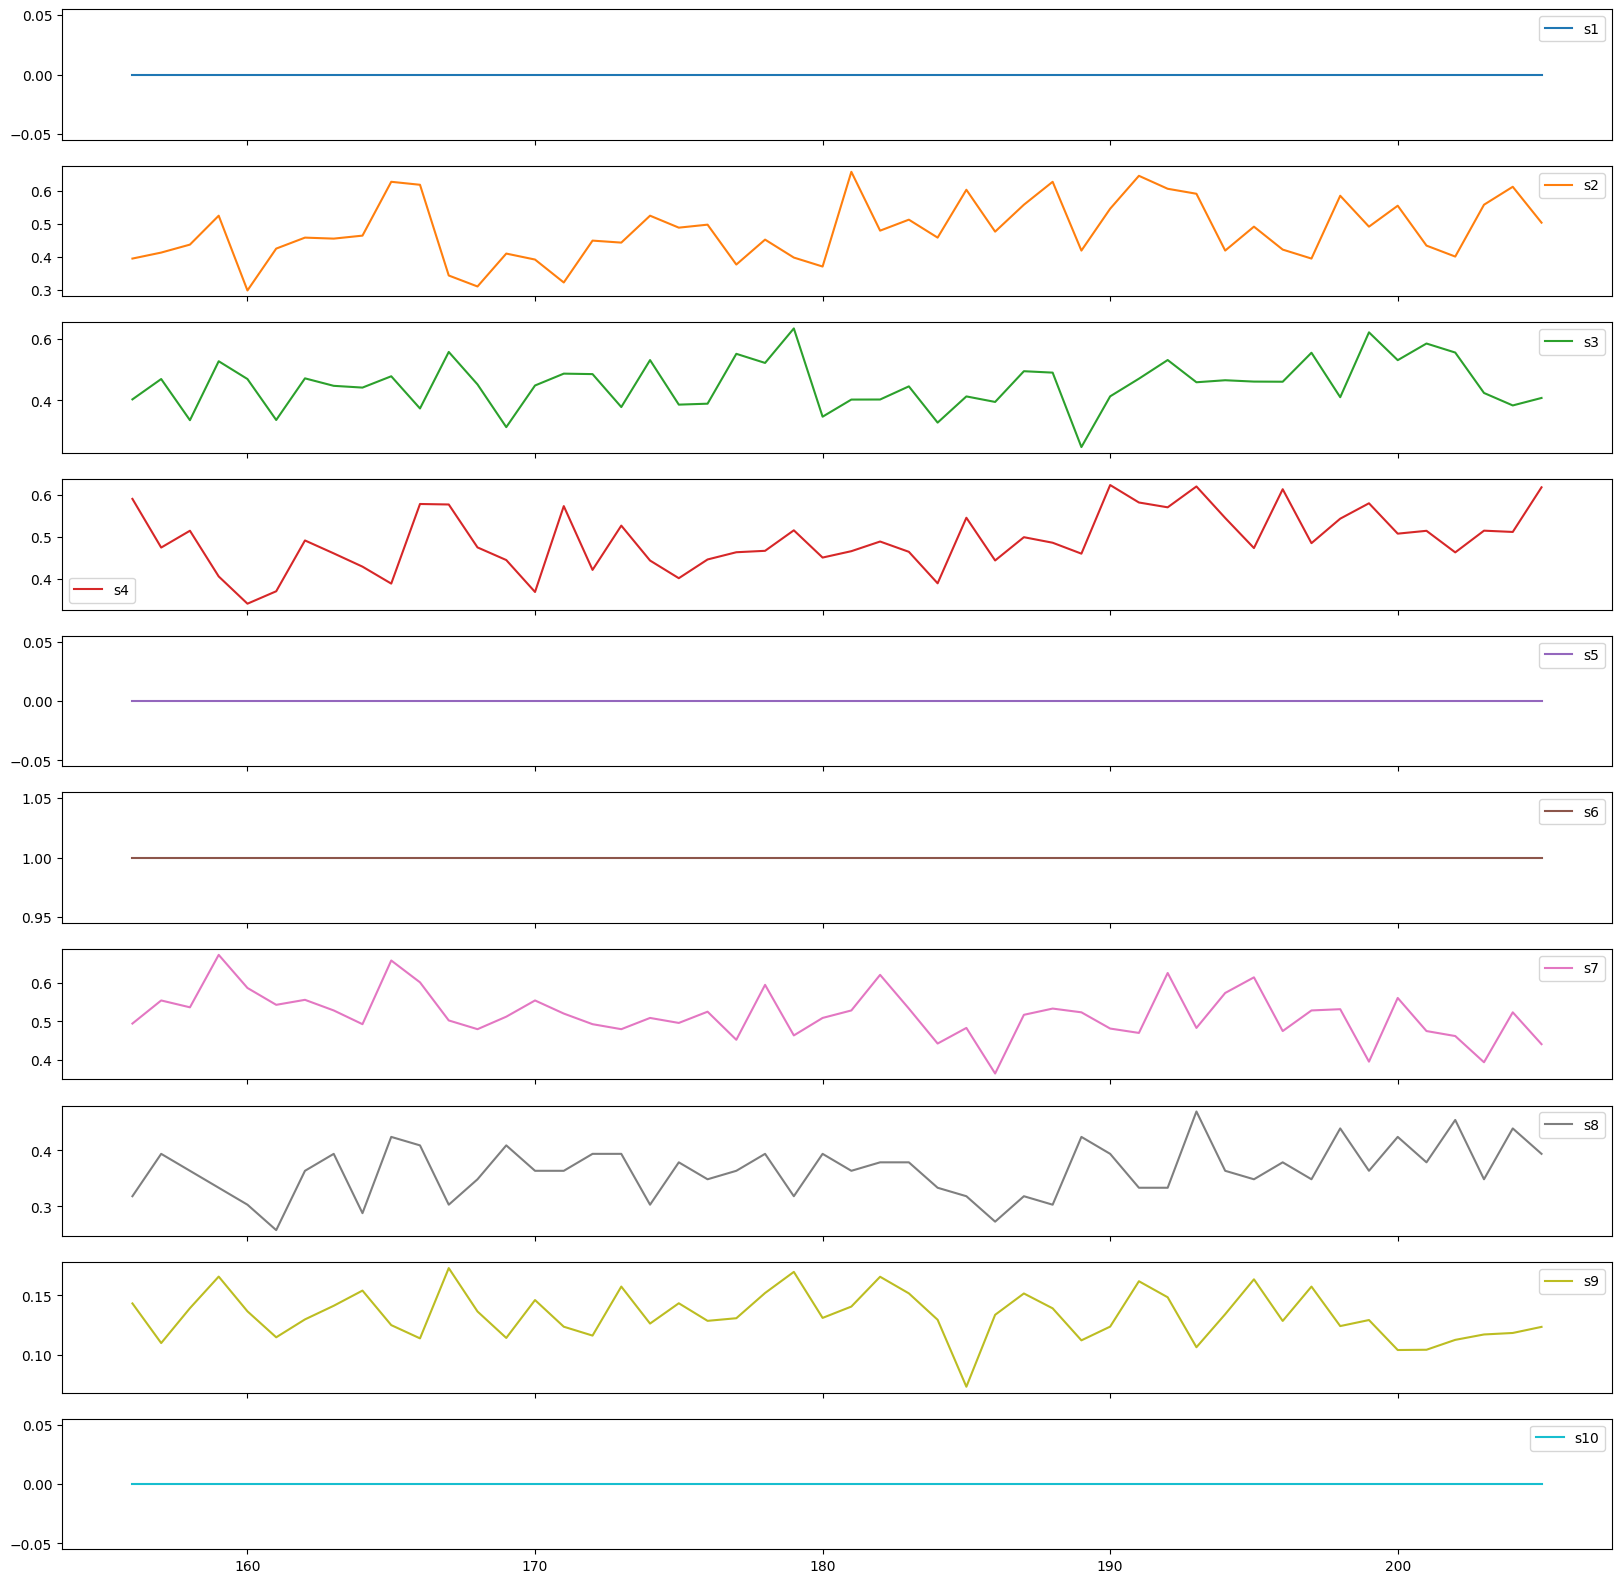

In [121]:
# get the last 50 datapoints for engine 3
engine_id3 = test_df[test_df['id'] == 3]
smallest_50_rul = engine_id3['RUL'].nsmallest(50)

# Filter the entire dataset based on the 50 smallest numbers in the "RUL" column
engine_id3 = engine_id3[engine_id3['RUL'].isin(smallest_50_rul)]

cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [115]:
# preparing data for visualizations 
# # window of 50 cycles prior to a failure point for engine id 3
# engine_id3 = test_df[test_df['id'] == 3]
# # engine_id3
# engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
# engine_id3_50cycleWindow
# cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
# engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
# cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
# engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# # plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
# ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
155,3,76,0.557471,0.083333,0.0,0.0,0.319277,0.367997,0.315496,0.0,...,0.0,0.583333,0.0,0.0,0.449612,0.408313,0.207756,119,0,0
156,3,77,0.350575,0.833333,0.0,0.0,0.394578,0.403314,0.590986,0.0,...,0.0,0.333333,0.0,0.0,0.472868,0.454571,0.210526,118,0,0
157,3,78,0.396552,0.583333,0.0,0.0,0.412651,0.469152,0.475186,0.0,...,0.0,0.500000,0.0,0.0,0.651163,0.560895,0.213296,117,0,0
158,3,79,0.511494,0.250000,0.0,0.0,0.436747,0.335949,0.515192,0.0,...,0.0,0.333333,0.0,0.0,0.635659,0.497514,0.216066,116,0,0
159,3,80,0.603448,0.750000,0.0,0.0,0.524096,0.526706,0.406482,0.0,...,0.0,0.500000,0.0,0.0,0.612403,0.663076,0.218837,115,0,0
160,3,81,0.425287,0.500000,0.0,0.0,0.298193,0.469152,0.341661,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.392433,0.221607,114,0,0
161,3,82,0.798851,0.166667,0.0,0.0,0.424699,0.336603,0.371202,0.0,...,0.0,0.416667,0.0,0.0,0.403101,0.596658,0.224377,113,0,0
162,3,83,0.442529,0.250000,0.0,0.0,0.457831,0.471332,0.492066,0.0,...,0.0,0.416667,0.0,0.0,0.558140,0.470036,0.227147,112,0,0
163,3,84,0.724138,0.583333,0.0,0.0,0.454819,0.447133,0.461344,0.0,...,0.0,0.583333,0.0,0.0,0.496124,0.555095,0.229917,111,0,0
164,3,85,0.442529,0.916667,0.0,0.0,0.463855,0.441465,0.429777,0.0,...,0.0,0.416667,0.0,0.0,0.496124,0.667633,0.232687,110,0,0


#### Model Building
##### Import libraries

###### Tensorflow Description
Numerical Computation: TensorFlow allows you to perform mathematical operations and numerical computations efficiently. It provides a computational graph framework that represents mathematical operations as nodes and data flow as edges, enabling efficient execution on CPUs, GPUs, or even distributed computing environments.

Machine Learning: TensorFlow includes a high-level API called **Keras**, which simplifies the process of building, training, and evaluating machine learning models. Keras provides a user-friendly interface and supports a variety of neural network architectures, making it easier to implement deep learning models.

Deep Learning: TensorFlow excels in deep learning applications and supports various neural network architectures, including convolutional neural networks (CNNs) for computer vision tasks, **recurrent neural networks (RNNs) for sequential data processing**, and transformers for natural language processing (NLP) tasks. TensorFlow also provides pre-trained models and tools for transfer learning.

Model Deployment: TensorFlow allows you to export trained models and deploy them in various production environments

In [1]:
# import the libraries
import tensorflow
import keras
#HDF5 File Handling: h5py allows you to create, read, write, and manipulate HDF5 files using a simple and intuitive Pythonic interface
import h5py
import os


In [2]:
import pickle
# regular expressions
import re

In [3]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation

##### Output files

In [4]:
# We'll serialize the model in json format
LSTM_MODEL = 'modellstm.json'

# and store the weights in h5
MODEL_WEIGHTS = 'modellstm.h5'

##### Why LSTM?
Perhaps the most attractive advantage of deep learning they automatically do feature engineering from the data, eliminating the need for the manual feature engineering step.

In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

We use the Keras LSTM with Tensorflow as a backend. Here layers expect an input in the shape of an array of 3 dimensions
 (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

We define a function to generate this array, as we'll use it repeatedly.

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]